<a href="https://colab.research.google.com/github/ssttefann/EmotionClassification/blob/master/bag_of_words_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Emotion Classificaton in Text**

In [44]:
from __future__ import absolute_import, division, print_function, unicode_literals

# General
import numpy as np
import pandas as pd
import re

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot') 
# plt.style.use('dark_background')

try:
  import pyprind
except Exception:
  !pip install pyprind
  import pyprind

# Data preprocessing
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

# SKLEARN 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading the data

In [2]:
# set the seed for entire process
# so that results can be reproducible
np.random.seed(123)

dataset = pd.read_csv("/content/drive/My Drive/emotion.data")
dataset.drop(dataset.columns[0], axis='columns', inplace=True)    # drop id column since it won't be used 
dataset = dataset.reindex(np.random.permutation(dataset.index))   # shuffle data 
dataset.head()

,text,emotions
98301,i am feeling melancholy and have finally pinpo...,sadness
41147,i miss having someone to talk to who i have th...,joy
151024,i just feel like i get blamed for everything,sadness
202104,i also apologize for mentioning about him in m...,anger
73602,im finding is the difference in having a life ...,joy


In [0]:
dataset.shape

(416809, 2)

# Visualization

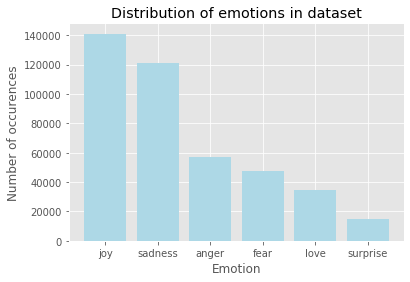

In [67]:
#x_ax = np.unique(dataset['emotions'])
x_ax = ['joy', 'sadness', 'anger', 'fear', 'love', 'surprise']
y_ax = [ np.count_nonzero(dataset['emotions'] == x) for x in x_ax]

plt.bar(x_ax, y_ax, color='lightblue')
plt.title("Distribution of emotions in dataset")
plt.xlabel("Emotion")
plt.ylabel("Number of occurences")
plt.show()

## Word clouds

In [0]:
from wordcloud import WordCloud

def generate_word_cloud(input_text):
    wordcloud = WordCloud(max_font_size=40, relative_scaling=.5).generate(input_text)
    plt.figure()
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

In [0]:
############### INDIVIDUAL PLOTS

fig = plt.figure(figsize=(15, 8))

emotion = 'love'

df = dataset.loc[dataset['emotions'] == emotion]
df = df['text'].tolist()
wordcloud = WordCloud(max_font_size=80).generate(" ".join(df))
plt.axis("off")
plt.title(emotion)
plt.imshow(wordcloud)

plt.savefig('/content/drive/My Drive/Colab Notebooks/individual/' + emotion +'.png')
plt.show()


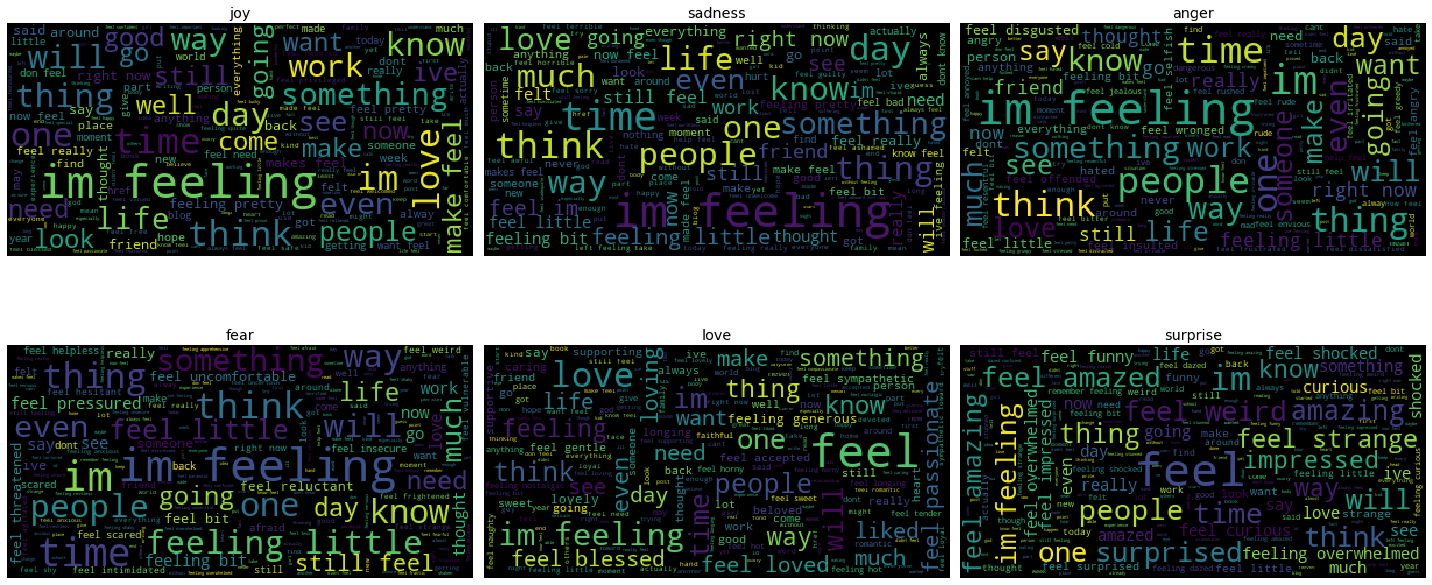

In [112]:
fig = plt.figure(figsize=(20, 10))

for idx,emotion in enumerate(x_ax):
  ax = fig.add_subplot(2, 3, idx+1)
  df = dataset.loc[dataset['emotions'] == emotion]
  df = df['text'].tolist()
  wordcloud = WordCloud(max_font_size=40, relative_scaling=.5).generate(" ".join(df))
  ax.axis("off")
  ax.set_title(emotion)
  ax.imshow(wordcloud)

plt.tight_layout()
plt.savefig('/content/drive/My Drive/Colab Notebooks/wc_facet.png')
plt.show()

# Preprocessing


 ## Stop words


In [38]:
try:
  stop = stopwords.words('english')
except LookupError:
  import nltk
  nltk.download('stopwords')
  stop = stopwords.words('english')

print(stop[:10])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


## Tokenezing

In [0]:

def tokenizer(text):
    ''' Removes stop words and special characters,
        and returns list of all words that are left

        Parameters
        -----------
        text : string 

        Returns
        ----------
        tokenized : list {string}
    '''

    text = re.sub('http.*', '', text)                               # delete link references
    text = re.sub('[\W]+', ' ', text.lower()).replace('-', '')
    tokenized = [w for w in text.split() if w not in stop]          # skip stop words
    return tokenized


In [40]:
string = 'neko je nesto rekao http www.gocml'

re.sub('http.*', '', string)

'neko je nesto rekao '

## Stemming


In [0]:
porter = PorterStemmer() 
def tokenizer_porter(text):
  return [porter.stem(word) for word in tokenizer(text)]

## Vectorization

In [0]:
# Hashing vectorizer
vect = HashingVectorizer(decode_error='ignore', 
                         n_features=2**18,
                         preprocessor=None, 
                         ngram_range=(1, 1),
                         tokenizer=tokenizer)

# Creating Train and test data

In [73]:
label2id = {"joy" : 0, "sadness" : 1, "anger" : 2, "fear" : 3, "love" : 4, "surprise" : 5}
id2label = {0 : "joy", 1 : "sadness", 2 : "anger", 3 : "fear", 4 : "love", 5 : "surprise"}

# label2id = { label : idx for idx, label in enumerate(set(dataset['emotions'].values))}
# id2label = { id : label for label, id in label2id.items()}

print(label2id)
print(id2label)

{'joy': 0, 'sadness': 1, 'anger': 2, 'fear': 3, 'love': 4, 'surprise': 5}
{0: 'joy', 1: 'sadness', 2: 'anger', 3: 'fear', 4: 'love', 5: 'surprise'}


In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset['text'].values, 
                                                    dataset['emotions'].values, 
                                                    test_size=0.1, 
                                                    random_state=123)

In [0]:
y_train = np.asarray([ label2id[val] for val in y_train])
y_test =  np.asarray([ label2id[val] for val in y_test])

# Training the model


In [45]:
# By setting the loss parameter to log loss this becomes a Logistic Regression Classifier
clf = SGDClassifier(loss='log', random_state=1, max_iter=1)

num_epochs = 100
pbar = pyprind.ProgBar(num_epochs)
classes = [x for x in label2id.values()]

for i in range(num_epochs):

    # number of elements in one batch
    size = int(len(X_train) / num_epochs)

    #starting index of a batch
    start = size * i

    #last index of a batch
    end = start + size 

    batch_x = X_train[start : end]
    batch_y = y_train[start : end]

    batch_x = vect.transform(batch_x)
    clf.partial_fit(batch_x, batch_y, classes=classes)
    pbar.update()

# some elements are possibly left over because of integer division
# so do one final partial fit
batch_x = X_train[end : ]
batch_y = y_train[end : ]

batch_x = vect.transform(batch_x)
clf.partial_fit(batch_x, batch_y, classes=classes)
pbar.update()


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:23


# Evaluating model's performance


In [61]:
test = vect.transform(X_test)
print('Accuracy: %.3f' % clf.score(test, y_test))

Accuracy: 0.841


# Testing on custom data

In [0]:
def predict(text, clf=clf, vectorizer=vect):
  ''' Predicts the label of the given text input

  Parameters
  ----------- 
  text : string
    text whose emotion we want to interpret
  clf : sklearn.linear_model
    Classifier
  vectorizer : sklearn.feature_extraction.text
    Vectorizer that represents text in a numerical form
  
  Returns 
  ----------
  label : string
    name of emotion which corresponds to the input

  '''

  val = clf.predict(vectorizer.transform([text]))
  return id2label[val[0]]

In [0]:
predict("Today has been a disaster so far")

'joy'

In [0]:
predict("Today has been a disaster so far. I feel so tired because my stupid boss made me do all his work")

'sadness'

In [0]:
predict("The cucumber looked great, but when I peeled it off, some of it fell apart. But the rest still tasted fine I guess")

In [0]:
predict("My mom is so stubborn she won't let me go anywhere!")

'surprise'

In [0]:
predict("When I found out Kobe Bryant died, i was shocked!")

'surprise'

In [0]:
clf.decision_function(vect.transform(["Today has been a disaster so far"]))

array([[-0.2515987 , -1.35084614, -1.66514546, -2.52430844, -2.18387111,
        -3.02946218]])

In [0]:
predict("I am unhappy")

'sadness'